## Notebook Purpose

Initial experiments with ConvDecoder, based upon the original notebook `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, load_output, save_output, \
                            expmt_already_generated
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
else:
    dtype = torch.FloatTensor

In [2]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

### Run expmts

In [21]:
slice_ksp_.dtype, slice_ksp_.shape

(dtype('complex64'), (15, 640, 372))

In [12]:
img_dc_list, img_est_list, img_gt_list = [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []
ssim_list, psnr_list = [], []

# file_id_list = ['1000273', '1000325', '1000464', '1000007', '1000537', '1000818', \
#                 '1001140', '1001219', '1001338', '1001598', '1001533', '1001798']
file_id_list = ['1001798']
NUM_ITER_LIST = [10000]
NUM_ITER = 1
ALPHA_LIST = [0]#, 0.125, 0.25, 0.375, 0.5]
ALPHA = 0
C_WMSE = None
DC_STEP = True

for idx, file_id in enumerate(file_id_list):  
    
    f, slice_ksp = load_h5(file_id) # load full mri measurements
    slice_ksp_ = slice_ksp
    print('file_id: {}'.format(file_id))

    
    mask, mask2d, mask1d = get_masks(f, slice_ksp) # load mask + variants, M
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step
    
#     for NUM_ITER in NUM_ITER_LIST:
    for ALPHA in ALPHA_LIST:
#     for C_WMSE in C_WMSE_LIST:
        
        # initialize net, net input seed, and scale slice_ksp accordingly
        print('shape slice_ksp', slice_ksp.shape)
        net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled
        img_gt_list.append(img_gt) # could do this once per loop
        
        if expmt_already_generated(file_id, NUM_ITER, DC_STEP, ALPHA):     
            img_dc, mse_wrt_ksp, mse_wrt_img = \
                load_output(file_id, NUM_ITER, DC_STEP, ALPHA)
            img_dc_list.append(img_dc)
            mse_wrt_ksp_list.append(mse_wrt_ksp)
            mse_wrt_img_list.append(mse_wrt_img)
            continue

        # for dc step - must do this after scaling slice_ksp
        ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]

        # apply mask to measurements for fitting model
        ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)

        print(ksp_masked.shape, img_masked.shape, mask2d.shape)
        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask2d,
            mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP, alpha=ALPHA,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype, c_wmse=C_WMSE)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})
        print(img_out.shape)
        
        
        img_dc, _ = data_consistency(img_out, slice_ksp, mask1d)
#         save_output(img_dc, mse_wrt_ksp, mse_wrt_img, \
#                     file_id, NUM_ITER, DC_STEP, ALPHA)

        # save images, metrics
        img_dc_list.append(img_dc)
        mse_wrt_ksp_list.append(mse_wrt_ksp)
        mse_wrt_img_list.append(mse_wrt_img)
        
for idx_ in range(len(img_dc_list)):
    _, _, ssim_, psnr_ = calc_metrics(img_dc_list[idx_], img_gt_list[idx_])
    ssim_list.append(ssim_)
    psnr_list.append(psnr_)
    
# np.save('img_dc_list.npy', img_dc_list)
# np.save('img_gt_list.npy', img_gt_list)
# np.save('ssim_list.npy', ssim_list)
# np.save('psnr_list.npy', psnr_list)

file_id: 1001798
shape slice_ksp (15, 640, 372)
torch.Size([1, 15, 640, 372, 2]) torch.Size([1, 30, 640, 372]) (640, 372)
torch.Size([1, 30, 640, 372]) (640, 372)
torch.Size([30, 640, 372])


In [8]:
from utils.helpers import num_params
params = [p.shape for p in net.parameters()]
params

[torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([160, 160, 3, 3]),
 torch.Size([160]),
 torch.Size([160]),
 torch.Size([30, 160, 1, 1])]

### Plot loss over iterations (mse_wrt_ksp or mse_wrt_img)

In [46]:
LIST_OI = ALPHA_LIST # or NUM_ITER_LIST, i.e. dimn of comparison
NUM_VARIANTS = len(LIST_OI) # number of different param sets for conv_decoder

In [47]:
mse_list = mse_wrt_ksp_list

for idx_im in range(len(file_id_list)): # for each img in expmt
    for idx_var in range(NUM_VARIANTS):
        print(mse_list[NUM_VARIANTS*idx_im+idx_var][-1])
        label = str(LIST_OI[idx_var]) # file_id_list[idx_im] # 
        plt.plot(mse_list[NUM_VARIANTS*idx_im+idx_var], label=label)
    plt.ylim(0,.05)
    plt.title('mse_wrt_ksp for varying alpha')
    plt.legend()
    plt.show()

TypeError: 'int' object is not subscriptable

# DOES THIS ACTUALLY WORK??

# TODO: RE-RUN AT 10K over many ALPHAS and many samples

### Compare ssim, psnr

In [52]:
DEC = 3 # number of decimals to display

# print average across different NUM_VARIANTS
for idx_var in range(NUM_VARIANTS):
    
    psnr_ = psnr_list[idx_var::NUM_VARIANTS] 
    ssim_ = ssim_list[idx_var::NUM_VARIANTS]
    print('ALPHA {}: psnr ~N({}, {}), ssim ~N({}, {})'.format(\
            LIST_OI[idx_var], np.round(np.mean(psnr_), DEC), \
            np.round(np.std(psnr_), DEC), np.round(np.mean(ssim_), DEC), \
            np.round(np.std(ssim_), DEC)))
print('')
    
#print for each sample
for idx_im in range(len(file_id_list)):    
    print('file_id {}'.format(file_id_list[idx_im]))
    for idx_var in range(NUM_VARIANTS):       
        ssim_ = ssim_list[NUM_VARIANTS*idx_im+idx_var]
        psnr_ = psnr_list[NUM_VARIANTS*idx_im+idx_var]
        print('ALPHA {}: {}, {}'.format(LIST_OI[idx_var], \
              np.round(ssim_, DEC), np.round(psnr_, DEC)), NUM_VARIANTS*idx_im+idx_var)            
    print('')

ALPHA 0: psnr ~N(28.224, 0.0), ssim ~N(0.63, 0.0)
ALPHA 0.125: psnr ~N(28.434, 0.0), ssim ~N(0.634, 0.0)
ALPHA 0.25: psnr ~N(29.747, 0.0), ssim ~N(0.673, 0.0)
ALPHA 0.375: psnr ~N(28.856, 0.0), ssim ~N(0.645, 0.0)
ALPHA 0.5: psnr ~N(28.814, 0.0), ssim ~N(0.646, 0.0)

file_id 1001798
ALPHA 0: 0.63, 28.224 0
ALPHA 0.125: 0.634, 28.434 1
ALPHA 0.25: 0.673, 29.747 2
ALPHA 0.375: 0.645, 28.856 3
ALPHA 0.5: 0.646, 28.814 4



### plot two samples w biggest delta b/w ALPHA=0, ALPHA=0.25 -- why does this difference exist?

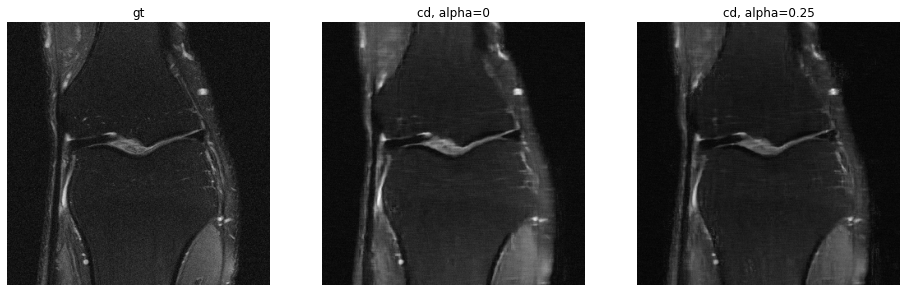

In [53]:
idx_to_check = 0

im_gt = img_gt_list[idx_to_check]
im1 = img_dc_list[idx_to_check]
im2 = img_dc_list[idx_to_check+2]

fig = plt.figure(figsize=(16, 8))

# plot gt
ax = fig.add_subplot(1,3,1)
ax.imshow(im_gt, cmap='gray')
ax.set_title('gt')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(im1, cmap='gray')
ax.set_title('cd, alpha=0')
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(im2, cmap='gray')
ax.set_title('cd, alpha=0.25')
ax.axis('off')

plt.show()

### Display, save images

In [14]:
NUM_VARIANTS = 3
var_title_list = ['cd, mse', 'cd, wmse, c=1', 'cd, wmse, c=1e5']

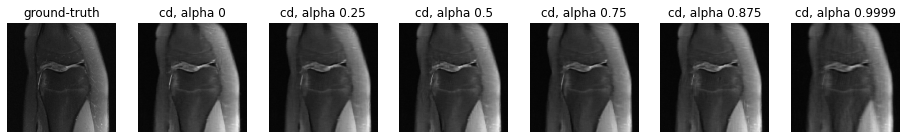

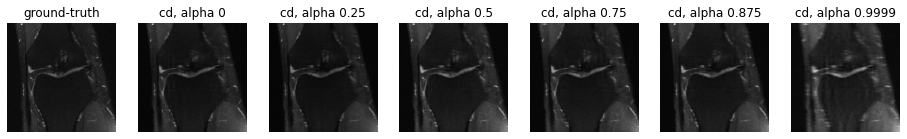

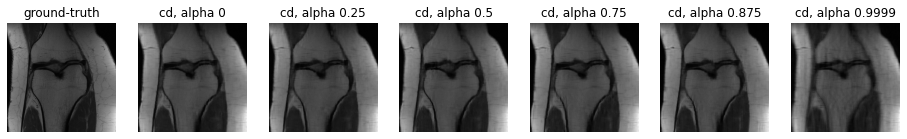

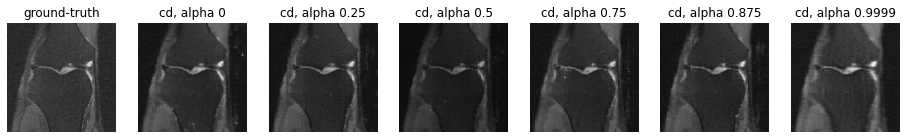

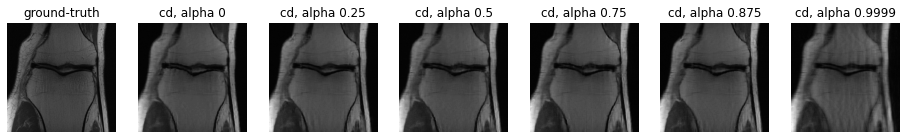

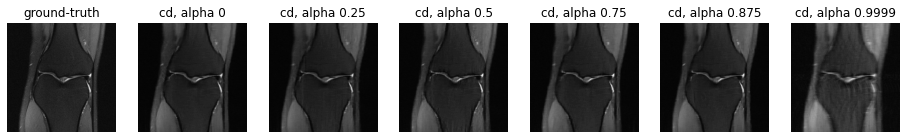

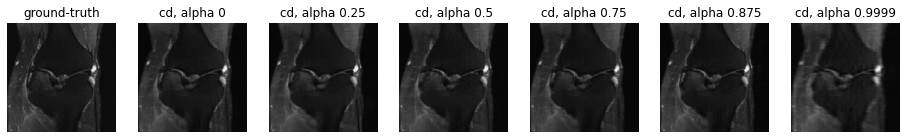

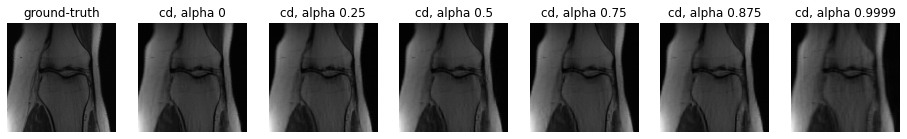

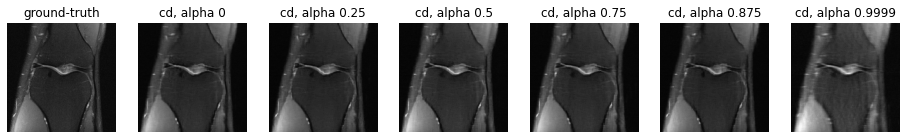

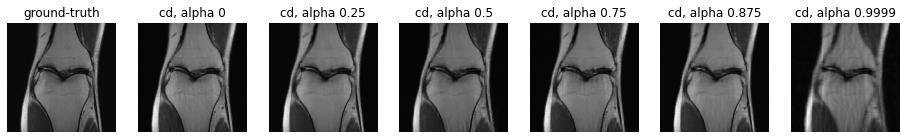

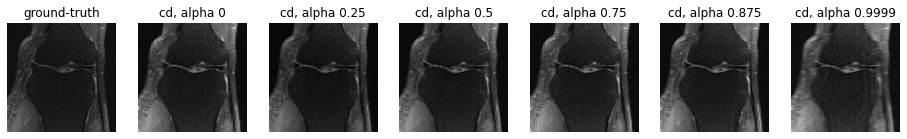

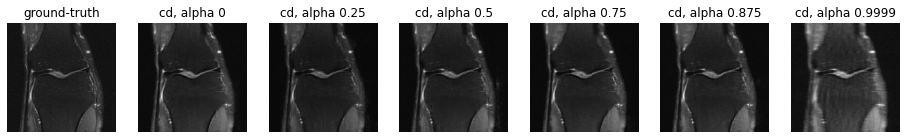

In [36]:
NUM_BASELINES = 1 # i.e. img_gt
NUM_COLS = NUM_VARIANTS + NUM_BASELINES # also want to plot img_gt

DIFF = False

for idx_im in range(len(file_id_list)): # for each img in expmt
    
    fig = plt.figure(figsize=(16, 8))

    # plot gt
    ax = fig.add_subplot(1,NUM_COLS,1)
    img_gt = img_gt_list[NUM_VARIANTS*idx_im]
    ax.imshow(img_gt, cmap='gray')
    ax.set_title('ground-truth')
    ax.axis('off')
    
    for idx_var in range(NUM_VARIANTS):
        ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
        img_oi = img_dc_list[NUM_VARIANTS*idx_im+idx_var]
        
        if DIFF:
            ax.imshow(img_oi-img_gt, cmap='gray')
        else:
            ax.imshow(img_oi, cmap='gray')
            
        ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var])))
#         ax.set_title(var_title_list[idx_var])
        ax.axis('off')
    
#     plt.savefig('plot_output/{}.pdf'.format(file_id_list[idx_im]), format='pdf')
    plt.show()

### Display images, diff(dc_100_iter, dc_10k_iter)

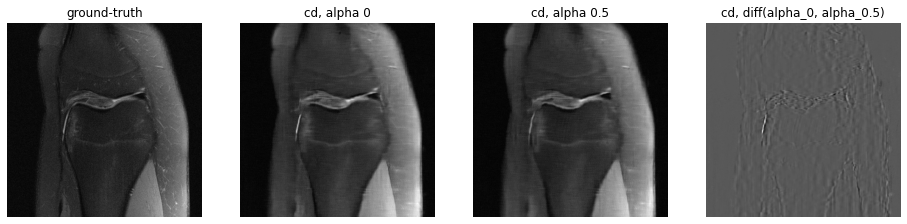

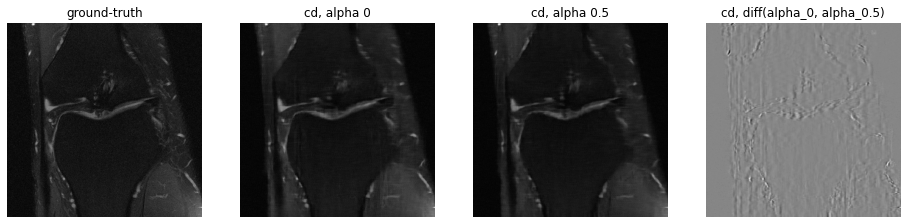

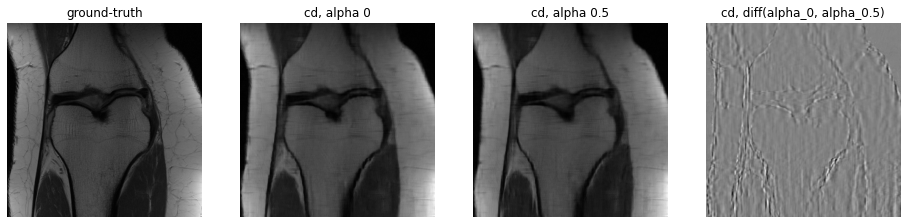

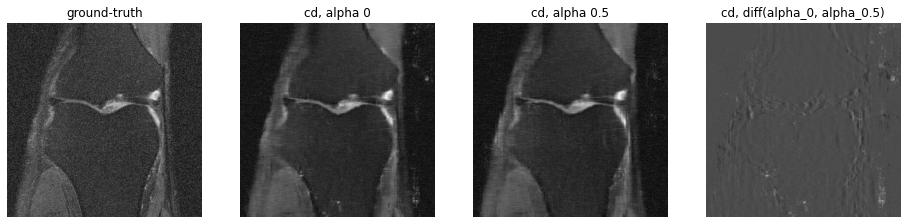

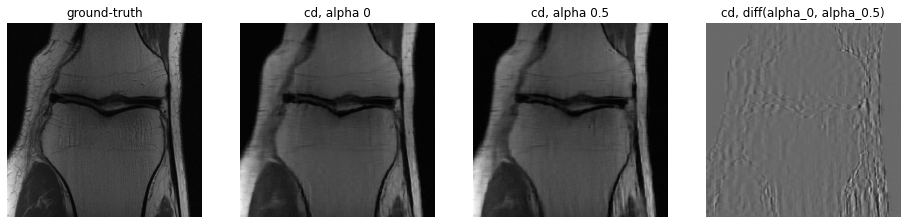

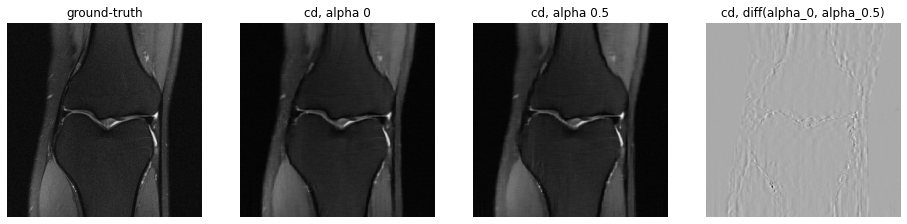

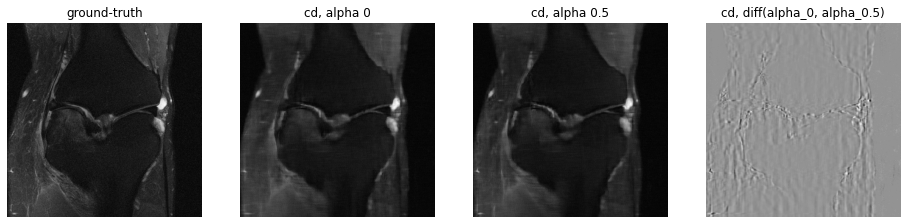

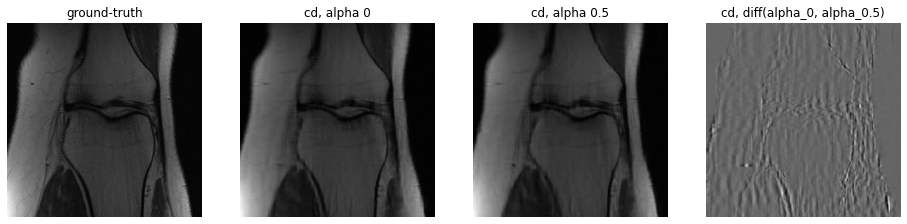

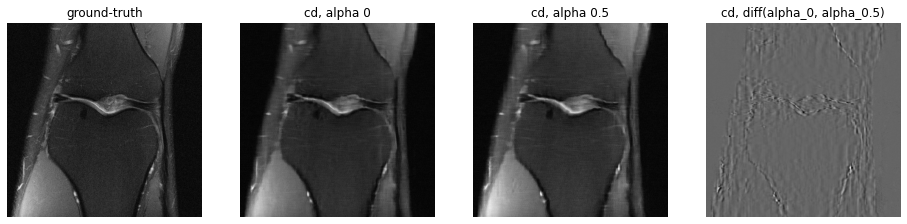

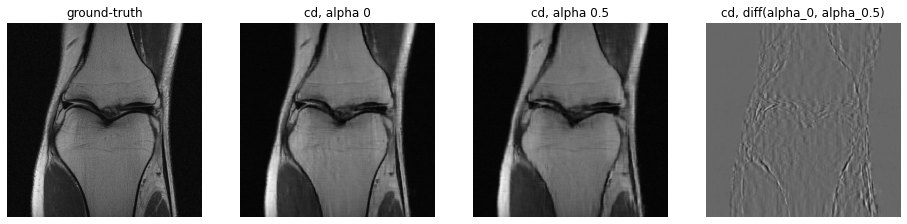

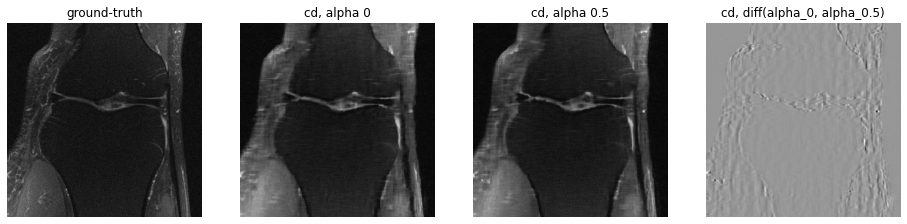

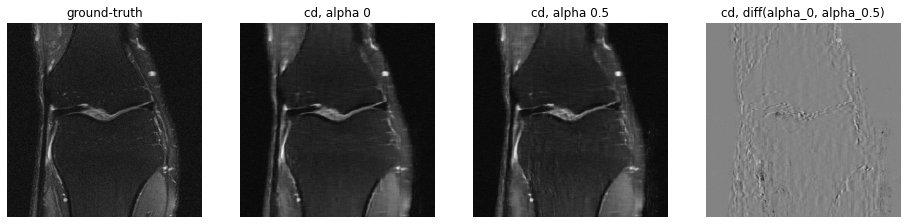

In [55]:
for idx_im in range(len(file_id_list)): # for each img in expmt
    
    fig = plt.figure(figsize=(16, 8))

    # plot gt
    ax = fig.add_subplot(1,NUM_COLS,1)
    img_gt = img_gt_list[NUM_VARIANTS*idx_im]
    ax.imshow(img_gt, cmap='gray')
    ax.set_title('ground-truth')
    ax.axis('off')
    
    for idx_var in range(NUM_VARIANTS):
        
        if idx_var == 0:
            img_100 = img_dc_list[NUM_VARIANTS*idx_im+idx_var]
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_100, cmap='gray')
            ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var])))
            ax.axis('off')
            continue
        elif idx_var == 1:
            OFFSET = 1 # want to get img at next idx_var=2
            img_10k = img_dc_list[NUM_VARIANTS*idx_im+idx_var+OFFSET]
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_10k, cmap='gray')
            ax.set_title('cd, alpha {}'.format(str(LIST_OI[idx_var+OFFSET])))
            ax.axis('off')
            continue
        elif idx_var == 2: # in last column, plot diff
            ax = fig.add_subplot(1,NUM_COLS,idx_var+NUM_BASELINES+1)
            ax.imshow(img_100-img_10k, cmap='gray')
            ax.set_title('cd, diff(alpha_0, alpha_0.5)')
            ax.axis('off')
    
#     plt.savefig('plot_output/{}.pdf'.format(file_id_list[idx_im]), format='pdf')
    plt.show()

In [ ]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()